In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import time

# 检查是否有可用的GPU
if torch.cuda.is_available():
    # 设置第二块GPU设备
    device = torch.device("cuda:1")  # "cuda:1" 表示第二块GPU
else:
    device = torch.device("cpu")  # 如果没有可用的GPU，则使用CPU
print(device)
num_workers=16
start_time = time.time()
# 定义前馈神经网络模型
class FeedforwardNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FeedforwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        
        self.fc2 = nn.Linear(hidden_size, 128)
        self.relu2 = nn.ReLU()
        
        self.fc3 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

# 定义前馈神经网络模型
class FeedforwardNN_LeakyReLU(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FeedforwardNN_LeakyReLU, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.LeakyReLU(negative_slope=0.01)
        
        self.fc2 = nn.Linear(hidden_size, 128)
        self.relu2 = nn.LeakyReLU(negative_slope=0.01)
        
        self.fc3 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

    # 定义Swish激活函数
class Swish(nn.Module):
    def __init__(self, beta=1.0):
        super(Swish, self).__init__()
        self.beta = beta

    def forward(self, x):
        return x * torch.sigmoid(self.beta * x)

class FeedforwardNN_swish(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FeedforwardNN_swish, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        #self.relu = nn.LeakyReLU(negative_slope=0.01)
        self.swish = Swish()  # 使用Swish激活函数
        self.fc2 = nn.Linear(hidden_size, 128)
        #self.relu2 = nn.LeakyReLU(negative_slope=0.01)
        self.swish2 = Swish()  # 使用Swish激活函数
        self.fc3 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.swish(out)
        out = self.fc2(out)
        out = self.swish2(out)
        out = self.fc3(out)
        return out

cuda:1


In [6]:
# 定义超参数
input_size = 28 * 28  # 输入特征的维度
hidden_size = 512  # 隐藏层的大小
num_classes = 10  # 类别的数量
learning_rate = 0.001  # 学习率
num_epochs = 20  # 迭代次数
batch_size = 64  # 批次大小

# 加载数据集
train_dataset = MNIST(root='~/Datasets/MNIST', train=True, transform=ToTensor(), download=True)
test_dataset = MNIST(root='~/Datasets/MNIST', train=False, transform=ToTensor(), download=False)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)



In [7]:
# 初始化模型
model_ReLU = FeedforwardNN(input_size, hidden_size, num_classes).to(device)
model_LeakyReLU = FeedforwardNN_LeakyReLU(input_size, hidden_size, num_classes).to(device)
model_Swish = FeedforwardNN_swish(input_size, hidden_size, num_classes).to(device)
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()

##定义不同的优化器
optimizer_ReLU = optim.Adam(model_ReLU.parameters(), lr=learning_rate)
optimizer_LeakyReLU = optim.Adam(model_LeakyReLU.parameters(), lr=learning_rate)
optimizer_Swish = optim.Adam(model_Swish.parameters(), lr=learning_rate)

def train_model(model, optimizer, activation_name):
    # 训练模型
    train_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0  # 用于累计每个epoch的总损失
        total_samples = 0

        for batch_idx, (data, targets) in enumerate(train_loader):
            data = data.view(-1, input_size).to(device)
            targets = targets.to(device)
            # 前向传播
            outputs = model(data)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * targets.size(0)  # 累计每个batch的损失
            total_samples += targets.size(0)

            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (batch_idx + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        avg_loss = total_loss / total_samples  # 计算每个epoch的平均损失
        train_losses.append(avg_loss)

        # 在测试集上评估模型
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for data, targets in test_loader:
                data = data.view(-1, input_size).to(device)
                targets = targets.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

            accuracy = correct / total
            test_accuracies.append(accuracy)
            print(f'Test Accuracy: {accuracy:.4f}')
    return train_losses,test_accuracies
# def train():
#     # 训练模型
#     for epoch in range(num_epochs):
#         model.train()
#         for batch_idx, (data, targets) in enumerate(train_loader):
#             data = data.view(-1, input_size).to(device)
#             targets=targets.to(device)
#             # 前向传播
#             outputs = model(data)
#             loss = criterion(outputs, targets)

#             # 反向传播和优化
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             if (batch_idx+1) % 100 == 0:
#                 print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')


#         # 在测试集上评估模型
#         model.eval()
#         with torch.no_grad():
#             correct = 0
#             total = 0
#             for data, targets in test_loader:
#                 data = data.view(-1, input_size).to(device)
#                 targets=targets.to(device)
#                 outputs = model(data)
#                 _, predicted = torch.max(outputs.data, 1)
#                 total += targets.size(0)
#                 correct += (predicted == targets).sum().item()

#             accuracy = correct / total
#             print(f'Test Accuracy: {accuracy:.4f}')
            


In [8]:
# 分别训练不同激活函数的模型并绘制图表
print("Training model with ReLU activation:")
train_losses,test_accuracies=train_model(model_ReLU, optimizer_ReLU, activation_name='ReLU')
end_time = time.time()
training_time = end_time - start_time
print("模型的training_time为"+str(round(training_time,2))+"秒" )

Training model with ReLU activation:
Epoch [1/20], Step [100/938], Loss: 0.3121
Epoch [1/20], Step [200/938], Loss: 0.2848
Epoch [1/20], Step [300/938], Loss: 0.1322
Epoch [1/20], Step [400/938], Loss: 0.2071
Epoch [1/20], Step [500/938], Loss: 0.2371
Epoch [1/20], Step [600/938], Loss: 0.2470
Epoch [1/20], Step [700/938], Loss: 0.1270
Epoch [1/20], Step [800/938], Loss: 0.0695
Epoch [1/20], Step [900/938], Loss: 0.0576
Test Accuracy: 0.9645
Epoch [2/20], Step [100/938], Loss: 0.2541
Epoch [2/20], Step [200/938], Loss: 0.1333
Epoch [2/20], Step [300/938], Loss: 0.0314
Epoch [2/20], Step [400/938], Loss: 0.1193
Epoch [2/20], Step [500/938], Loss: 0.1232
Epoch [2/20], Step [600/938], Loss: 0.1927
Epoch [2/20], Step [700/938], Loss: 0.1375
Epoch [2/20], Step [800/938], Loss: 0.0410
Epoch [2/20], Step [900/938], Loss: 0.1008
Test Accuracy: 0.9772
Epoch [3/20], Step [100/938], Loss: 0.0628
Epoch [3/20], Step [200/938], Loss: 0.0854
Epoch [3/20], Step [300/938], Loss: 0.0186
Epoch [3/20], St

Epoch [20/20], Step [800/938], Loss: 0.0001
Epoch [20/20], Step [900/938], Loss: 0.0006
Test Accuracy: 0.9814
模型的training_time为256.99秒


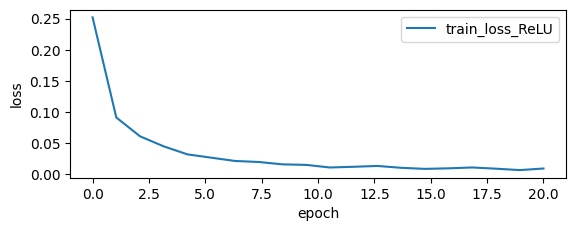

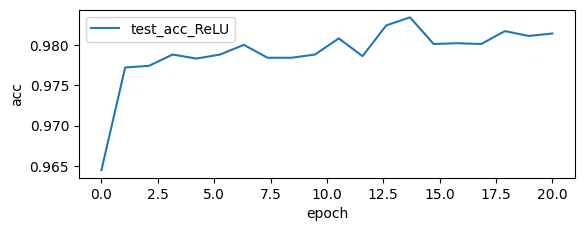

In [16]:
import matplotlib.pyplot as plt
import numpy as np
x=np.linspace(0,len(train_losses),len(train_losses))
plt.subplot(2, 1, 1)
plt.plot(x,train_losses,label="train_loss_ReLU",linewidth=1.5)
# plt.plot(x,test_accuracies,label="test_loss_ReLU",linewidth=1.5)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

x=np.linspace(0,len(test_accuracies),len(test_accuracies))
plt.subplot(2, 1, 2) 
plt.plot(x,test_accuracies,label="test_acc_ReLU",linewidth=1.5)
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend()
plt.show()

In [27]:
# 分别训练不同激活函数的模型并绘制图表
print("\nTraining model with LeakyReLU activation:")
model_LeakyReLU2 = FeedforwardNN_LeakyReLU(input_size, hidden_size, num_classes).to(device)
optimizer_LeakyReLU2 = optim.Adam(model_LeakyReLU2.parameters(), lr=learning_rate)
train_losses2,test_accuracies2=train_model(model_LeakyReLU2, optimizer_LeakyReLU2, activation_name='LeakyReLU2')
end_time = time.time()
training_time = end_time - start_time
print("模型的training_time为"+str(round(training_time,2))+"秒" )


Training model with LeakyReLU activation:
Epoch [1/20], Step [100/938], Loss: 0.2556
Epoch [1/20], Step [200/938], Loss: 0.4699
Epoch [1/20], Step [300/938], Loss: 0.2914
Epoch [1/20], Step [400/938], Loss: 0.1218
Epoch [1/20], Step [500/938], Loss: 0.1591
Epoch [1/20], Step [600/938], Loss: 0.1908
Epoch [1/20], Step [700/938], Loss: 0.1531
Epoch [1/20], Step [800/938], Loss: 0.1061
Epoch [1/20], Step [900/938], Loss: 0.1676
Test Accuracy: 0.9665
Epoch [2/20], Step [100/938], Loss: 0.1368
Epoch [2/20], Step [200/938], Loss: 0.1138
Epoch [2/20], Step [300/938], Loss: 0.1045
Epoch [2/20], Step [400/938], Loss: 0.1092
Epoch [2/20], Step [500/938], Loss: 0.1090
Epoch [2/20], Step [600/938], Loss: 0.0632
Epoch [2/20], Step [700/938], Loss: 0.1280
Epoch [2/20], Step [800/938], Loss: 0.0748
Epoch [2/20], Step [900/938], Loss: 0.0133
Test Accuracy: 0.9729
Epoch [3/20], Step [100/938], Loss: 0.0400
Epoch [3/20], Step [200/938], Loss: 0.0446
Epoch [3/20], Step [300/938], Loss: 0.0548
Epoch [3/2

Epoch [20/20], Step [800/938], Loss: 0.0269
Epoch [20/20], Step [900/938], Loss: 0.0000
Test Accuracy: 0.9830
模型的training_time为2852.71秒


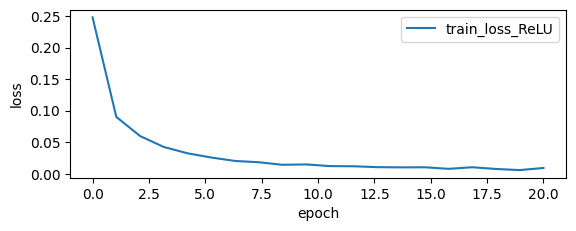

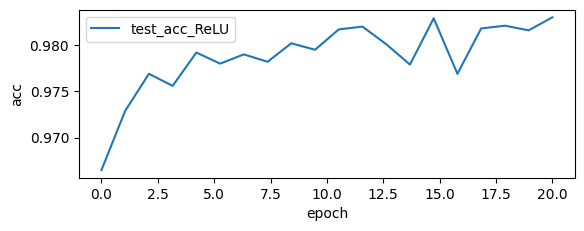

In [28]:
import matplotlib.pyplot as plt
import numpy as np
x=np.linspace(0,len(train_losses),len(train_losses))
plt.subplot(2, 1, 1)
plt.plot(x,train_losses2,label="train_loss_ReLU",linewidth=1.5)
# plt.plot(x,test_accuracies,label="test_loss_ReLU",linewidth=1.5)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

plt.show()

x=np.linspace(0,len(test_accuracies),len(test_accuracies))
plt.subplot(2, 1, 2) 
plt.plot(x,test_accuracies2,label="test_acc_ReLU",linewidth=1.5)
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend()
plt.show()

In [20]:
# 分别训练不同激活函数的模型并绘制图表
print("\nTraining model with LeakyReLU activation:")
train_losses3,test_accuracies3=train_model(model_Swish, optimizer_Swish, activation_name='optimizer_Swish')
end_time = time.time()
training_time = end_time - start_time
print("模型的training_time为"+str(round(training_time,2))+"秒" )


Training model with LeakyReLU activation:
Epoch [1/20], Step [100/938], Loss: 0.2198
Epoch [1/20], Step [200/938], Loss: 0.1993
Epoch [1/20], Step [300/938], Loss: 0.1780
Epoch [1/20], Step [400/938], Loss: 0.1193
Epoch [1/20], Step [500/938], Loss: 0.3120
Epoch [1/20], Step [600/938], Loss: 0.1910
Epoch [1/20], Step [700/938], Loss: 0.0969
Epoch [1/20], Step [800/938], Loss: 0.0778
Epoch [1/20], Step [900/938], Loss: 0.1450
Test Accuracy: 0.9609
Epoch [2/20], Step [100/938], Loss: 0.1488
Epoch [2/20], Step [200/938], Loss: 0.0506
Epoch [2/20], Step [300/938], Loss: 0.0579
Epoch [2/20], Step [400/938], Loss: 0.1082
Epoch [2/20], Step [500/938], Loss: 0.1215
Epoch [2/20], Step [600/938], Loss: 0.0750
Epoch [2/20], Step [700/938], Loss: 0.0822
Epoch [2/20], Step [800/938], Loss: 0.0500
Epoch [2/20], Step [900/938], Loss: 0.0709
Test Accuracy: 0.9743
Epoch [3/20], Step [100/938], Loss: 0.0598
Epoch [3/20], Step [200/938], Loss: 0.0477
Epoch [3/20], Step [300/938], Loss: 0.0573
Epoch [3/2

Epoch [20/20], Step [800/938], Loss: 0.0131
Epoch [20/20], Step [900/938], Loss: 0.0131
Test Accuracy: 0.9816
模型的training_time为2376.41秒


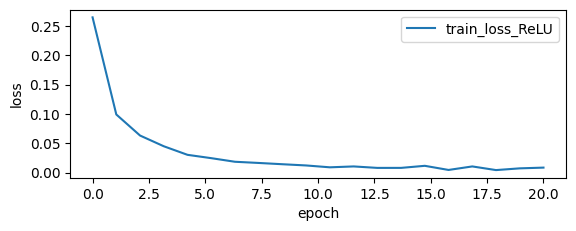

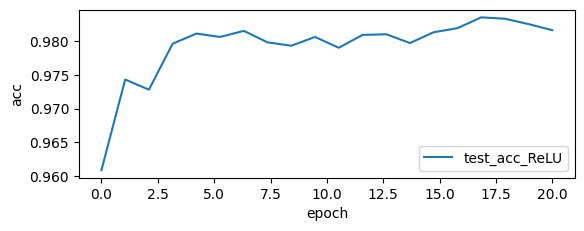

In [21]:
import matplotlib.pyplot as plt
import numpy as np
x=np.linspace(0,len(train_losses),len(train_losses))
plt.subplot(2, 1, 1)
plt.plot(x,train_losses3,label="train_loss_ReLU",linewidth=1.5)
# plt.plot(x,test_accuracies,label="test_loss_ReLU",linewidth=1.5)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

x=np.linspace(0,len(test_accuracies),len(test_accuracies))
plt.subplot(2, 1, 2) 
plt.plot(x,test_accuracies3,label="test_acc_ReLU",linewidth=1.5)
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend()
plt.show()

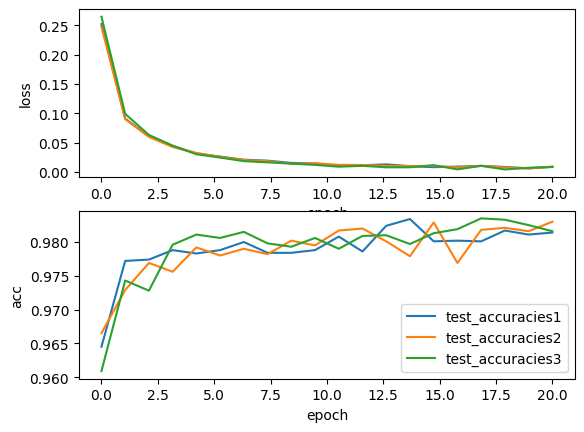

In [29]:
import matplotlib.pyplot as plt
x=np.linspace(0,len(train_losses),len(train_losses))
plt.subplot(2, 1, 1)
plt.plot(x,train_losses,label="train_losses1",linewidth=1.5)
plt.plot(x,train_losses2,label="train_losses2",linewidth=1.5)
plt.plot(x,train_losses3,label="train_losses3",linewidth=1.5)
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")


x=np.linspace(0,len(test_accuracies),len(test_accuracies))
plt.subplot(2, 1, 2)
plt.plot(x,test_accuracies,label="test_accuracies1",linewidth=1.5)
plt.plot(x,test_accuracies2,label="test_accuracies2",linewidth=1.5)
plt.plot(x,test_accuracies3,label="test_accuracies3",linewidth=1.5)
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend()
plt.show()


In [ ]:
# 保存模型
torch.save(model.state_dict(), 'multi_class_model.pth')

In [ ]:
# 加载模型
model = FeedforwardNN(input_size, hidden_size, num_classes)
model.load_state_dict(torch.load('multi_class_model.pth'))


In [ ]:
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 训练模型
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.view(-1, input_size)
        
        # 前向传播
        outputs = model(data)
        loss = criterion(outputs, targets)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (batch_idx+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    # 在测试集上评估模型
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for data, targets in test_loader:
            data = data.view(-1, input_size)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
        
        accuracy = correct / total
        print(f'Test Accuracy: {accuracy:.4f}')
